In [ ]:
# install dependencies
!pip install datasets transformers

In [3]:
import transformers, datasets

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!apt install git-lfs

Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [6]:
import transformers

print(transformers.__version__)

4.28.1


In [29]:
from transformers.utils import send_example_telemetry
send_example_telemetry('language_modeling_notebook', framework='pytorch')

## **Fine-tuning a language model**
In this notebook, we'll see how to fine-tune one of the 🤗 [Transformers](https://github.com/huggingface/transformers) model on a language modeling tasks. We will cover two types of language modeling tasks which are:

*   Causal language modeling: the model has to predict the next token in the sentence (so the labels are the same as the inputs shifted to the right). To make sure the model does not cheat, it gets an attention mask that will prevent it to access the tokens after token i when trying to predict the token i+1 in the sentence.
*   Masked language modeling: the model has to predict some tokens that are masked in the input. It still has access to the whole sentence, so it can use the tokens before and after the tokens masked to predict their value.



### Preparing the dataset

In [30]:
from datasets import load_dataset
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1')

  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
dataset['train'][10]

{'text': ' The game \'s battle system , the BliTZ system , is carried over directly from Valkyira Chronicles . During missions , players select each unit using a top @-@ down perspective of the battlefield map : once a character is selected , the player moves the character around the battlefield in third @-@ person . A character can only act once per @-@ turn , but characters can be granted multiple turns at the expense of other characters \' turns . Each character has a field and distance of movement limited by their Action Gauge . Up to nine characters can be assigned to a single mission . During gameplay , characters will call out if something happens to them , such as their health points ( HP ) getting low or being knocked out by enemy attacks . Each character has specific " Potentials " , skills unique to each character . They are divided into " Personal Potential " , which are innate skills that remain unaltered unless otherwise dictated by the story and can either help or impede

In [31]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML 

def show_random_elements(dataset, num_examples=10) :
  assert num_examples <= len(dataset), "Can't pich more elements than there are in the dataset"

  picks=[]

  for _ in range(num_examples) :
    pick = random.randint(0, len(dataset)-1)
    while pick in picks : 
      pick = random.randint(0, len(dataset)-1)
    picks.append(pick)

  df = pd.DataFrame(dataset[picks])

  for col, typ in dataset.features.items() :
    if isinstance(typ, ClassLabel) :
      df[column] = df[column].transform(lambda i: typ.names[i])

  display(HTML(df.to_html()))

In [32]:
show_random_elements(dataset["train"])

,text
0,"During the second tournament , Liu Kang meets Kitana , and the two engage romantically with each other in this timeline too . It is during this tournament that Kang begins to doubt Raiden 's visions after he ordered him and Kung Lao not to rescue Kitana , and when Lao is killed by Shao Kahn . He seemingly kills Shao Kahn , and avenges his fallen friend . However , Kahn survives , and begins plotting to invade Earthrealm . \n"
1,
2,= = = = Mongol – Song alliance = = = = \n
3,"Almost as soon as the Jin armies had left Kaifeng , Emperor Qinzong reneged on the deal and dispatched two armies to repel the Jurchen troops attacking Taiyuan and bolster the defenses of Zhongshan and Hejian . An army of 90 @,@ 000 soldiers and another of 60 @,@ 000 were defeated by Jin forces by June . A second expedition to rescue Taiyuan was also unsuccessful . \n"
4,"Bradford City became the first league football team from the county , before they even had a team or played a game . They and Chelsea , who were elected to the league two years later , share the distinction of being the only clubs to join the league without having played a competitive fixture . A summer archery contest , which had been organised to raise money for the rugby league club , was used to finance the new club , and Manningham 's colours of claret and amber were adopted as Bradford City 's kit , but with Manningham 's hoops changed to stripes . \n"
5,"The oral legends and texts initiate a process of Sanskritization of the folk deity Khandoba by elevating him to the classical Hindu god Shiva ; his two principal wives Mhalsa and Banai are equated to Parvati and Ganga . Banai does not appear in the Sanskrit Malhari Mahatmya , the main scripture related to Khandoba , however it mentions Ganga arriving from heaven . Banai ( Ganga ) has a quarrel with Mhalsa ( Parvati ) , ultimately ending with the message that both are the same . Some Dhangars consider Banai also to be a form of Parvati . \n"
6,= = = Early career = = = \n
7,"Mac Mohan as Sambha , Gabbar Singh 's sidekick \n"
8,"In the 1950s , the New Zealand Wildlife Service was established and began making regular expeditions to search for the kakapo , mostly in Fiordland and what is now the Kahurangi National Park in the northwest of the South Island . Seven Fiordland expeditions between 1951 and 1956 found only a few recent signs . Finally , in 1958 a kakapo was caught and released in the Milford Sound catchment area in Fiordland . Six more kakapo were captured in 1961 ; one was released and the other five were transferred to the aviaries of the Mount Bruce Bird Reserve near Masterton in the North Island . Within months , four of the birds had died and the fifth died after about four years . In the next 12 years , regular expeditions found few signs of the kakapo , indicating that numbers were continuing to decline . Only one bird was captured in 1967 ; it died the following year . \n"
9,"Tropical Storm Olaf was an erratic and long @-@ lived tropical cyclone that brought heavy rainfall to regions of Mexico , which would be devastated by Hurricane Pauline a week later . The sixteenth named storm of the 1997 season , Olaf formed on September 26 off the southern coast of Mexico . It moved northward and quickly intensified , reaching peak winds of 70 mph ( 120 km / h ) before weakening and hitting Oaxaca as a tropical depression . In Mexico , El Salvador , and Guatemala , the system brought heavy rainfall , which killed 18 people and caused flooding and damage . It was originally thought that Olaf dissipated over Mexico , although its remnants continued westward for a week . It interacted with Hurricane Pauline , which caused Olaf to turn to the southeast and later to the north to strike Mexico again , finally dissipating on October 12 . \n"


# **Causal Language model**

For causal language modeling (CLM) we are going to take all the texts in our dataset and concatenate them after they are tokenized. Then we will split them in examples of a certain sequence length. This way the model will receive chunks of contiguous text that may look like:

part of text 1

or

end of text 1 [BOS_TOKEN] beginning of text 2

depending on whether they span over several of the original texts in the dataset or not. The labels will be the same as the inputs, shifted to the left.

For causal language model we will use [DistilGPT2](https://huggingface.co/distilgpt2) or ou can pick any of the checkpoints listed [here](https://huggingface.co/models?other=causal-lm) instead.

In [33]:
model_checkpoint = "distilgpt2"

In [34]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast = True)

In [35]:
def tokenize_function(examples) :
  return tokenizer(examples['text'])

In [ ]:
tokenized_dataset = dataset.map(tokenize_function, batched=True, num_proc=4, remove_columns=['text'])

In [37]:
tokenized_dataset['train'][1]

{'input_ids': [796, 569, 18354, 7496, 17740, 6711, 796, 220, 198],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

We need to concatenate all our texts together then split the result in small chunks of a certain block_size. To do this, we will use the map method again, with the option batched=True. This option actually lets us change the number of examples in the datasets by returning a different number of examples than we got. This way, we can create our new samples from a batch of examples.

First, we grab the maximum length our model was pretrained with. This might be a big too big to fit in your GPU RAM, so here we take a bit less at just 128.

In [38]:
block_size = 128

In [39]:
def group_texts(examples) : 
  concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
  total_length = len(concatenated_examples[list(examples.keys())[0]])
  # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
  # customize this part to your needs.

  total_length = (total_length // block_size) * block_size

  result = {
      k : [t[i : i+block_size] for i in range(0, total_length, block_size)] for k, t in concatenated_examples.items()
  }

  result['labels'] = result['input_ids'].copy()

  return result

Also note that by default, the map method will send a batch of 1,000 examples to be treated by the preprocessing function. So here, we will drop the remainder to make the concatenated tokenized texts a multiple of block_size every 1,000 examples. You can adjust this behavior by passing a higher batch size (which will also be processed slower). You can also speed-up the preprocessing by using multiprocessing:

In [ ]:
lm_datasets = tokenized_dataset.map(
    group_texts,
    batched=True,
    batch_size=4000,
    num_proc=4
)

In [42]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

' game and follows the " Nameless ", a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven ". \n The game began development in 2010, carrying over a large portion of the work done on Valkyria Chronicles II. While it retained the standard features of the series, it also underwent multiple adjustments, such as making the game more forgiving for series newcomers. Character designer Raita Honjou and composer Hitoshi Sakimoto both returned from previous entries, along with Valkyria Chronicles II director Takeshi Oz'

In [43]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the hub_model_id argument to set the repo name (it needs to be the full name, including your namespace: for instance "sgugger/gpt-finetuned-wikitext2" or "huggingface/gpt-finetuned-wikitext2").

In [44]:
from transformers import Trainer, TrainingArguments

model_name = model_checkpoint.split("/")[-1]
training_arguments = TrainingArguments(
    f"{model_name}-finetuned-wikitext2",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
)

trainer.train()

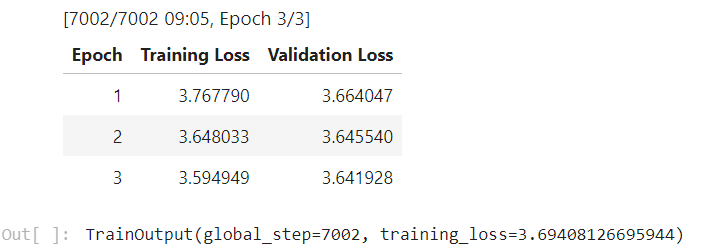

In [ ]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

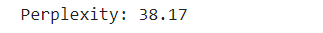

In [ ]:
trainer.push_to_hub()

# **Masked Language Model**

For masked language modeling (MLM) we are going to use the same preprocessing as before for our dataset with one additional step: we will randomly mask some tokens (by replacing them by [MASK]) and the labels will be adjusted to only include the masked tokens (we don't have to predict the non-masked tokens).

We will use the [distilroberta-base model](https://huggingface.co/distilroberta-base) for this example. You can pick any of the checkpoints listed [here](https://huggingface.co/models?other=masked-lm) instead:

In [23]:
model_checkpoint = "distilroberta-base"

In [24]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast = True)
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    num_proc=4,
    remove_columns=["text"]
                              )

Map (num_proc=4):   0%|          | 0/4358 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


Map (num_proc=4):   0%|          | 0/36718 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


Map (num_proc=4):   0%|          | 0/3760 [00:00<?, ? examples/s]

In [25]:
lm_dataset = tokenized_dataset.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc = 4,
)

Map (num_proc=4):   0%|          | 0/4358 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/36718 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3760 [00:00<?, ? examples/s]

In [26]:
from transformers import AutoModelForMaskedLM
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

In [27]:
model_name = model_checkpoint.split("/")[-1]

training_arguments = TrainingArguments(
    f"{model_name}-finetuned-wikitext2",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=True,
)

Finally, we use a special data_collator. The data_collator is a function that is responsible of taking the samples and batching them in tensors. In the previous example, we had nothing special to do, so we just used the default for this argument. Here we want to do the random-masking. We could do it as a pre-processing step (like the tokenization) but then the tokens would always be masked the same way at each epoch. By doing this step inside the data_collator, we ensure this random masking is done in a new way each time we go over the data.

To do this masking for us, the library provides a DataCollatorForLanguageModeling. We can adjust the probability of the masking:

In [28]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer = tokenizer, mlm_probability=0.15)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    data_collator=data_collator,
)

trainer.train()

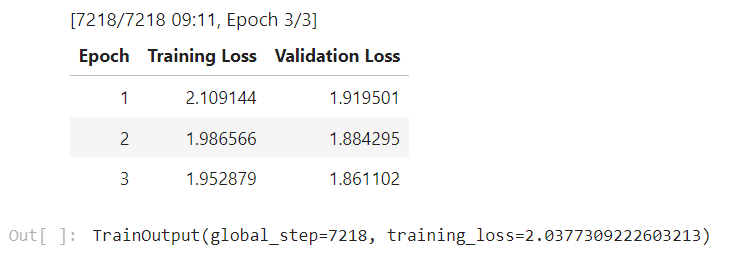

Like before, we can evaluate our model on the validation set. The perplexity is much lower than for the CLM objective because for the MLM objective, we only have to make predictions for the masked tokens (which represent 15% of the total here) while having access to the rest of the tokens. It's thus an easier task for the model.

In [ ]:
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

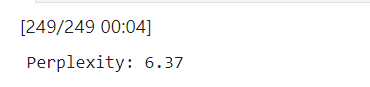

In [ ]:
trainer.push_to_hub()